In [1]:
import numpy
import matplotlib.pyplot
import itertools
import functools
import operator
import os
import random
import scipy.misc

In [2]:
def img2chromosome(img_arr):
    """
    First step in GA is to represent/encode the input as a sequence of characters.
    The encoding used is value encoding by giving each gene in the 
    chromosome its actual value in the image.
    Image is converted into a chromosome by reshaping it as a single row vector.
    """
    chromosome = numpy.reshape(a=img_arr, 
                               newshape=(functools.reduce(operator.mul, 
                                                          img_arr.shape)))
    return chromosome

In [3]:
def initial_population(img_shape, n_individuals=8):
    """
    Creating an initial population randomly.
    """
    # Empty population of chromosomes accoridng to the population size specified.
    init_population = numpy.empty(shape=(n_individuals, 
                                  functools.reduce(operator.mul, img_shape)),
                                  dtype=numpy.uint8)
    for indv_num in range(n_individuals):
        # Randomly generating initial population chromosomes genes values.
        init_population[indv_num, :] = numpy.random.random(
                                functools.reduce(operator.mul, img_shape))*256
    return init_population

In [4]:
def chromosome2img(chromosome, img_shape):
    """
    First step in GA is to represent the input in a sequence of characters.
    The encoding used is value encoding by giving each gene in the chromosome 
    its actual value.
    """
    img_arr = numpy.reshape(a=chromosome, newshape=img_shape)
    return img_arr

In [5]:
def fitness_fun(target_chrom, indiv_chrom):
    """
    Calculating the fitness of a single solution.
    The fitness is basicly calculated using the sum of absolute difference 
    between genes values in the original and reproduced chromosomes.
    """
    quality = numpy.mean(numpy.abs(target_chrom-indiv_chrom))
    """
    Negating the fitness value to make it increasing rather than decreasing.
    Actually the next line adds nothing but it exists just because it is known 
    that the fitness values are increasing not decreasing.
    """
    quality = numpy.sum(target_chrom) - quality
    return quality

In [6]:
def cal_pop_fitness(target_chrom, pop):
    """
    This method calculates the fitness of all solutions in the population.
    """
    qualities = numpy.zeros(pop.shape[0])
    for indv_num in range(pop.shape[0]):
        # Calling fitness_fun(...) to get the fitness of the current solution.
        qualities[indv_num] = fitness_fun(target_chrom, pop[indv_num, :])
    return qualities

In [7]:
def select_mating_pool(pop, qualities, num_parents):
    """
    Selects the best individuals in the current generation, according to the 
    number of parents specified, for mating and generating a new better population.
    """
    parents = numpy.empty((num_parents, pop.shape[1]), dtype=numpy.uint8)
    for parent_num in range(num_parents):
        # Retrieving the best unselected solution.
        max_qual_idx = numpy.where(qualities == numpy.max(qualities))
        max_qual_idx = max_qual_idx[0][0]
        # Appending the currently selected 
        parents[parent_num, :] = pop[max_qual_idx, :]
        """
        Set quality of selected individual to a negative value to not get 
        selected again. Algorithm calcululations will just make qualities >= 0.
        """
        qualities[max_qual_idx] = -1
    return parents

In [8]:
def crossover(parents, img_shape, n_individuals=8):
    """
    Applying crossover operation to the set of currently selected parents to 
    create a new generation.
    """
    new_population = numpy.empty(shape=(n_individuals, 
                                        functools.reduce(operator.mul, img_shape)),
                                        dtype=numpy.uint8)
    
    """
    Selecting the best previous parents to be individuals in the new generation.
    **Question** Why using the previous parents in the new population?
    It is recommened to use the previous best solutions (parents) in the new 
    generation in addition to the offspring generated from these parents and 
    not use just the offspring.
    The reason is that the offspring may not produce the same fitness values 
    generated by their parents. Offspring may be worse than their parents.
    As a result, if none of the offspring are better, the previous generations 
    winners will be reselected until getting a better offspring.
    """
    #Previous parents (best elements).
    new_population[0:parents.shape[0], :] = parents


    # Getting how many offspring to be generated. If the population size is 8 and number of parents mating is 4, then number of offspring to be generated is 4.
    num_newly_generated = n_individuals-parents.shape[0]
    # Getting all possible permutations of the selected parents.
    parents_permutations = list(itertools.permutations(iterable=numpy.arange(0, parents.shape[0]), r=2))
    # Randomly selecting the parents permutations to generate the offspring.
    selected_permutations = random.sample(range(len(parents_permutations)), 
                                          num_newly_generated)
    
    comb_idx = parents.shape[0]
    for comb in range(len(selected_permutations)):
        # Generating the offspring using the permutations previously selected randmly.
        selected_comb_idx = selected_permutations[comb]
        selected_comb = parents_permutations[selected_comb_idx]
        
        # Applying crossover by exchanging half of the genes between two parents.
        half_size = numpy.int32(new_population.shape[1]/2)
        new_population[comb_idx+comb, 0:half_size] = parents[selected_comb[0], 
                                                             0:half_size]
        new_population[comb_idx+comb, half_size:] =  parents[selected_comb[1], 
                                                             half_size:]
    
    return new_population

In [9]:
def mutation(population, num_parents_mating, mut_percent):
    """
    Applying mutation by selecting a predefined percent of genes randomly.
    Values of the randomly selected genes are changed randmly.
    """
    for idx in range(num_parents_mating, population.shape[0]):
        # A predefined percent of genes are selected randomly.
        rand_idx = numpy.uint32(numpy.random.random(size=numpy.uint32(mut_percent/100*population.shape[1]))
                                                    *population.shape[1])
        # Changing the values of the selected genes randomly.
        new_values = numpy.uint8(numpy.random.random(size=rand_idx.shape[0])*256)
        # Updating population after mutation.
        population[idx, rand_idx] = new_values
    return population

In [10]:
def save_images(curr_iteration, qualities, new_population, im_shape, 
                save_point, save_dir):
    """
    Saving best solution in a given generation as an image in the specified directory.
    Images are saved accoirding to stop points to avoid saving images from 
    all generations as saving mang images will make the algorithm slow.
    """
    if(numpy.mod(curr_iteration, save_point)==0):
        # Selecting best solution (chromosome) in the generation.
        best_solution_chrom = new_population[numpy.where(qualities == 
                                                         numpy.max(qualities))[0][0], :]
        # Decoding the selected chromosome to return it back as an image.
        best_solution_img = chromosome2img(best_solution_chrom, im_shape)
        # Saving the image in the specified directory.
        matplotlib.pyplot.imsave(save_dir+'solution_'+str(curr_iteration)+'.png', best_solution_img)


In [11]:
def show_indivs(individuals, im_shape):
    """
    Show all individuals as image in a single graph.
    """
    num_ind = individuals.shape[0]
    fig_row_col = 1
    for k in range(1, numpy.uint16(individuals.shape[0]/2)):
        if numpy.floor(numpy.power(k, 2)/num_ind) == 1:
            fig_row_col = k
            break
    fig1, axis1 = matplotlib.pyplot.subplots(fig_row_col, fig_row_col)

    curr_ind = 0
    for idx_r in range(fig_row_col):
        for idx_c in range(fig_row_col):
            if(curr_ind>=individuals.shape[0]):
                break
            else:
                curr_img = chromosome2img(individuals[curr_ind, :], im_shape)
                axis1[idx_r, idx_c].imshow(curr_img)
                curr_ind = curr_ind + 1

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Reading target image to be reproduced using Genetic Algorithm (GA).
import cv2
target_im = cv2.imread('/content/drive/My Drive/fruit.jpg')
# Target image after enconding. Value encoding is used.
target_chromosome = img2chromosome(target_im)

In [18]:
# Population size
#sol_per_pop = 8
sol_per_pop = 10
# Mating pool size
#num_parents_mating = 4
num_parents_mating = 4
# Mutation percentage
#mutation_percent = .01
mutation_percent = .005

In [19]:
"""
There might be inconsistency between the number of selected mating parents and 
number of selected individuals within the population.
In some cases, the number of mating parents are not sufficient to 
reproduce a new generation. If that occurred, the program will stop.
"""
num_possible_permutations = len(list(itertools.permutations(iterable=numpy.arange(0, 
                                                            num_parents_mating), r=2)))
num_required_permutations = sol_per_pop-num_possible_permutations
if(num_required_permutations>num_possible_permutations):
    print(
    "\n*Inconsistency in the selected populatiton size or number of parents.*"
    "\nImpossible to meet these criteria.\n"
    )
    sys.exit(1)

In [20]:
# Creating an initial population randomly.
new_population = initial_population(img_shape=target_im.shape, 
                                         n_individuals=sol_per_pop)

In [21]:
for iteration in range(10000):
    # Measing the fitness of each chromosome in the population.
    qualities = cal_pop_fitness(target_chromosome, new_population)
    print('Quality : ', numpy.max(qualities), ', Iteration : ', iteration)
    
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, qualities, 
                                      num_parents_mating)
    
    # Generating next generation using crossover.
    new_population = crossover(parents, target_im.shape, 
                                    n_individuals=sol_per_pop)

    """
    Applying mutation for offspring.
    Mutation is important to avoid local maxima. Avoiding mutation makes 
    the GA falls into local maxima.
    Also mutation is important as it adds some little changes to the offspring. 
    If the previous parents have some common degaradation, mutation can fix it.
    Increasing mutation percentage will degarde next generations.
    """
    new_population = mutation(population=new_population, 
                                   num_parents_mating=num_parents_mating, 
                                   mut_percent=mutation_percent)
    """
    Save best individual in the generation as an image for later visualization.
    """
    save_images(iteration, qualities, new_population, target_im.shape, 
                     save_point=500, save_dir=os.curdir+'//')

Streaming output truncated to the last 5000 lines.
Quality :  27444774.969465397 , Iteration :  5000
Quality :  27444774.97158264 , Iteration :  5001
Quality :  27444774.972336907 , Iteration :  5002
Quality :  27444774.976293504 , Iteration :  5003
Quality :  27444774.977537382 , Iteration :  5004
Quality :  27444774.97825857 , Iteration :  5005
Quality :  27444774.980938204 , Iteration :  5006
Quality :  27444774.981963743 , Iteration :  5007
Quality :  27444774.98262538 , Iteration :  5008
Quality :  27444774.98505359 , Iteration :  5009
Quality :  27444774.986892946 , Iteration :  5010
Quality :  27444774.989473335 , Iteration :  5011
Quality :  27444774.990902476 , Iteration :  5012
Quality :  27444774.991941247 , Iteration :  5013
Quality :  27444774.994647346 , Iteration :  5014
Quality :  27444774.99731375 , Iteration :  5015
Quality :  27444775.000827048 , Iteration :  5016
Quality :  27444775.000827048 , Iteration :  5017
Quality :  27444775.003473602 , Iteration :  5018
Qual

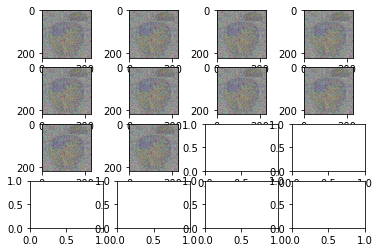

In [22]:
# Display the final generation
show_indivs(new_population, target_im.shape)